# Exploring the data collected by HealthKit

### Exporting the data
In the Health App hit your profile, then the "Export all Health Data" button. AirDrop the zip to your computer in a directory you can use then unzip using `unzip export.zip`

In [1]:
!tree apple_health_export
# !pip install bokeh

apple_health_export
├── export.xml
├── export_cda.xml
└── workout-routes
    ├── route_2019-08-13_11.27am.gpx
    ├── route_2019-08-18_9.35am.gpx
    ├── route_2019-08-26_4.05pm.gpx
    ├── route_2019-09-04_3.57pm.gpx
    ├── route_2019-09-08_1.47pm.gpx
    ├── route_2019-09-11_4.37pm.gpx
    ├── route_2019-09-16_4.44pm.gpx
    ├── route_2019-09-23_10.32am.gpx
    ├── route_2019-09-23_3.38pm.gpx
    └── route_2019-10-29_5.09pm.gpx

1 directory, 12 files


In [2]:
import pandas as pd
import xmltodict
import json
import pickle
import numpy as np

In [3]:
def read_file(name):
    with open(name) as f:
        contents = f.read()
    
    xml = xmltodict.parse(contents)
    return xml

health = read_file("apple_health_export/export.xml")
clinical = read_file("apple_health_export/export_cda.xml")

In [4]:
# for k in health["HealthData"].keys():
#     print(k)

# ActivitySummary

In [5]:
def parse_file(xml):
    health_data = xml["HealthData"]
    for key in health_data.keys():
        with open(f"pkl/{str(key)}.pkl", 'wb') as f:
            pickle.dump(health_data[key], f)
    

parse_file(health)
# parse_file(clinical)

In [6]:
def flatten_nested(df, nested):
    df = df.copy()
    meta = pd.DataFrame()
    
    for i, array in enumerate(df[nested].values):
        d = {}
        if type(array) is list:
            for ord_dict in array:
                d[ord_dict['@key']] = ord_dict['@value']
        elif type(array) is float:
            d[''] = ''
        else:
            # contains only key and value
            d[array['@key']] = array['@value']
        meta = meta.append(d, ignore_index=True)
    return pd.concat([df, meta], axis=1)

def convertColumn(name, col):
    if "date" in name.lower():
        # I can't find any documentation on the "-1000" so I am just removing it :)
        return col.str.strip("-1000").astype("datetime64[ns]")
    if "value" in name.lower():
        return pd.to_numeric(col, errors='coerce')
    return pd.to_numeric(col, errors='ignore')

def data_cleaning(dataframe, nested_column, flatten = True):
    if flatten:        
        dataframe = flatten_nested(dataframe, nested_column)
        
    for c in dataframe:
        dataframe[c] = convertColumn(c, dataframe[c])
    dataframe.columns = dataframe.columns.str.replace('@','')
    return dataframe


In [7]:
with open("pkl/Workout.pkl", 'rb') as f:
    Workout = pd.DataFrame(pickle.load(f))
    workout_df = data_cleaning(Workout, 'MetadataEntry')
    # Oi looks like we have an outlier (forgot to stop a workout recording for 20hours)
    workout_df = workout_df.drop(162)

In [8]:
with open("pkl/ActivitySummary.pkl", 'rb') as f:
    Activity = pd.DataFrame(pickle.load(f))
    # this data set doesn't need much cleaning :)
    Activity.columns = Activity.columns.str.replace('@','')
    activity_df = Activity

In [9]:
with open("pkl/Record.pkl", 'rb') as f:
    Record = pd.DataFrame(pickle.load(f))
    record_df = data_cleaning(Record, 'MetadataEntry', flatten=False)

In [129]:
# Record.info(memory_usage='deep')
# pd.to_numeric(record_df.value)

types = record_df.type.unique()
print(types)
audio = record_df[record_df.type == 'HKQuantityTypeIdentifierHeadphoneAudioExposure']

['HKQuantityTypeIdentifierHeight' 'HKQuantityTypeIdentifierBodyMass'
 'HKQuantityTypeIdentifierHeartRate' 'HKQuantityTypeIdentifierStepCount'
 'HKQuantityTypeIdentifierDistanceWalkingRunning'
 'HKQuantityTypeIdentifierBasalEnergyBurned'
 'HKQuantityTypeIdentifierActiveEnergyBurned'
 'HKQuantityTypeIdentifierFlightsClimbed'
 'HKQuantityTypeIdentifierAppleExerciseTime'
 'HKQuantityTypeIdentifierRestingHeartRate'
 'HKQuantityTypeIdentifierVO2Max'
 'HKQuantityTypeIdentifierWalkingHeartRateAverage'
 'HKQuantityTypeIdentifierHeadphoneAudioExposure'
 'HKQuantityTypeIdentifierAppleStandTime'
 'HKCategoryTypeIdentifierSleepAnalysis'
 'HKCategoryTypeIdentifierAppleStandHour'
 'HKCategoryTypeIdentifierMenstrualFlow'
 'HKCategoryTypeIdentifierMindfulSession'
 'HKCategoryTypeIdentifierMenstrualSymptomAbdominalCramps'
 'HKCategoryTypeIdentifierMenstrualSymptomBreastTenderness'
 'HKQuantityTypeIdentifierHeartRateVariabilitySDNN']


In [11]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

(Timestamp('2019-10-05 13:29:10'), Timestamp('2019-11-18 12:52:46'))

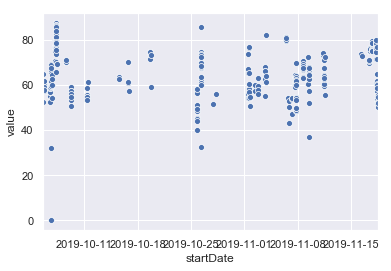

In [12]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

audio = record_df[record_df.type == 'HKQuantityTypeIdentifierHeadphoneAudioExposure']
plt.xlim(pd.to_datetime('2019-10-05 13:29:10'), pd.to_datetime('2019-11-18 12:52:46'))
ax = sns.scatterplot(x="startDate", y="value", data=audio)
audio.startDate.min(), audio.startDate.max()
# plt.xlim(pd.to_datetime('2019-10-05 13:29:10'), pd.to_datetime('2019-11-18 12:52:46'))


In [13]:
audio.startDate.min(), audio.startDate.max()


(Timestamp('2019-10-05 13:29:10'), Timestamp('2019-11-18 12:52:46'))

In [154]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, output_file, show
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
import matplotlib.pyplot as plt

from bokeh.models import  ColumnDataSource, Range1d, LabelSet, Label
from bokeh.palettes import viridis

def getTime(row, col):
    return row[col].time()

# workout_df.apply(getTime, col="startDate", axis=1)

def pretty_graph(df, x_col, y_col, cat, x_label, y_label, title):
    source_df = ColumnDataSource(data={
            'x': df[x_col],
            'y': df[y_col],
            cat: df[cat]
    })
        
    
    # cant figure out why passing dataframe alone isnt working?
    # source_df = ColumnDataSource(data=workout_df)
    TOOLTIPS = f"Burned $y calories in $x minutes doing @{cat}"  
    p = figure(
        width = 1000,
            x_axis_label=x_label,
            y_axis_label=y_label,
            title=title,
            tools='hover', 
            tooltips=TOOLTIPS
    )
        
    index_cmap = factor_cmap(cat, palette=viridis(10), 
                         factors=sorted(df[cat].unique()))
    p.scatter('x', 'y', source = source_df, fill_alpha=0.6, fill_color=index_cmap, size=10, legend_field=cat)
    
    return p


# show the results
output_notebook()
# print(source_df.data)


Loading BokehJS ...

Next up is following this tutorial:https://blog.davidvassallo.me/2019/03/11/embedding-bokeh-into-a-reactjs-app-using-bokehjs/

to embed the interesting bokeh graphs in a react website....

In [159]:
p = pretty_graph(workout_df, "duration", "totalEnergyBurned", "workoutActivityType", "Duration", "Calories Burned", "Duration of exercise correlated versus calories burned?")
show(p)

None


In [175]:
# workout_times = workout_df.startDate.dt.time
# print(workout_times)
from bokeh.models import HoverTool
from bokeh.models.formatters import DatetimeTickFormatter


def timestamp_graph(df, x_col, y_col, cat, x_label, y_label, title):
    source_df = ColumnDataSource(data={
                'x': df.apply(getTime, col=x_col, axis=1),
                'y': df[y_col],
                cat: df[cat]
    })
        
    
    # cant figure out why passing dataframe alone isnt working?
    # source_df = ColumnDataSource(data=workout_df)
    TOOLTIPS = f"Burned $y calories in $x minutes doing @{cat}"  
    
    hover = HoverTool(
        tooltips = [
            ("Index", "$index"),
            ("Time", "@x{%H:%M:%S} hours"),
        ],
        formatters={
            'x': 'datetime',
        },
    )
    
    p = figure(
        width = 1000,
        x_axis_label=x_label,
        y_axis_label=y_label,
        title=title,
    )
    p.xaxis.formatter=DatetimeTickFormatter(hours="%H",minutes="%H:%M")
        
    p.add_tools(hover)
    
    index_cmap = factor_cmap(cat, palette=viridis(10), 
                         factors=sorted(df[cat].unique()))
    p.scatter('x', 'y', source = source_df, fill_alpha=0.6, fill_color=index_cmap, size=10)#, legend_field=cat)
    
    return p


# show the results
output_notebook()


p = timestamp_graph(workout_df, "startDate", "totalEnergyBurned", "workoutActivityType", "Time of day", "Are calories Burned", "Calories burned correlated with start time of exercise?")
show(p)



Loading BokehJS ...

In [108]:
workout_times = workout_df.startDate.dt.time

In [176]:
workout_df.iloc[86]

workoutActivityType        HKWorkoutActivityTypeFunctionalStrengthTraining
duration                                                            8.4728
durationUnit                                                           min
totalDistance                                                            0
totalDistanceUnit                                                       mi
totalEnergyBurned                                                  39.5977
totalEnergyBurnedUnit                                                 kcal
sourceName                                         Cassandra’s Apple Watch
sourceVersion                                                        5.0.1
device                   <<HKDevice: 0x2813d7e30>, name:Apple Watch, ma...
creationDate                                           2019-03-07 18:35:54
startDate                                              2019-03-07 18:27:23
endDate                                                2019-03-07 18:35:51
MetadataEntry            